In [9]:
%load_ext autoreload
%autoreload 2
import h5py, os
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 
import glob
import matplotlib.pyplot as plt
from scipy import signal
import json
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def parse_proto(example_protos):
    """Parse TFRecord protobuf."""

    # define features
    features = {
    TFR_INPUT: tf.io.FixedLenFeature([], tf.string),
    TFR_OUTPUT: tf.io.FixedLenFeature([], tf.string)
    }

    # parse example into features
    parsed_features = tf.io.parse_single_example(example_protos, features=features)

    # decode sequence
    sequence = tf.io.decode_raw(parsed_features[TFR_INPUT], tf.uint8)
    sequence = tf.reshape(sequence, [1024, 4])
    sequence = tf.cast(sequence, tf.float32)

    # decode targets
    targets = tf.io.decode_raw(parsed_features[TFR_OUTPUT], tf.float16)
    # if not raw:
    targets = tf.reshape(targets, [32, 7])
    targets = tf.cast(targets, tf.float32)

    return sequence, targets

def plot_one_seq(cov_list):
    fig, axs = plt.subplots(2, num_labels, figsize=(20,6))
    for i,cov in enumerate(cov_list):
        x = tf.cast(cov, 'complex64')
        axs[0,i].plot(tf.signal.fft(x), c='r')
        axs[0,i].set_xlim([0,x_len])
        axs[1,i].plot(cov, c='g')
        axs[1,i].set_ylim([0,400])
    fig.tight_layout()

In [11]:
TFR_INPUT = 'sequence'
TFR_OUTPUT = 'target'
n_plots = 3
num_labels = 7
x_len = 32/2


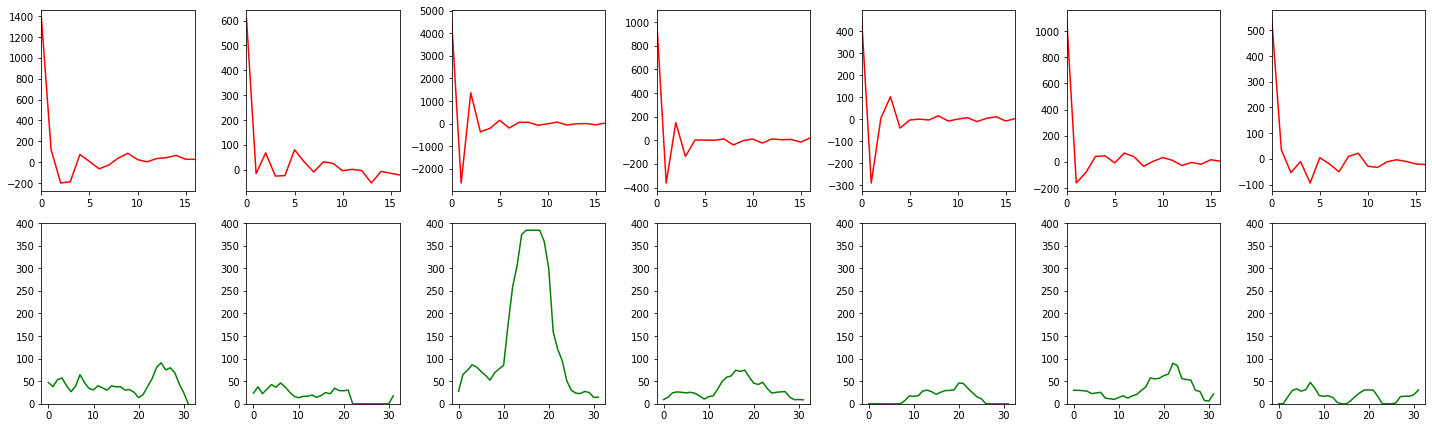

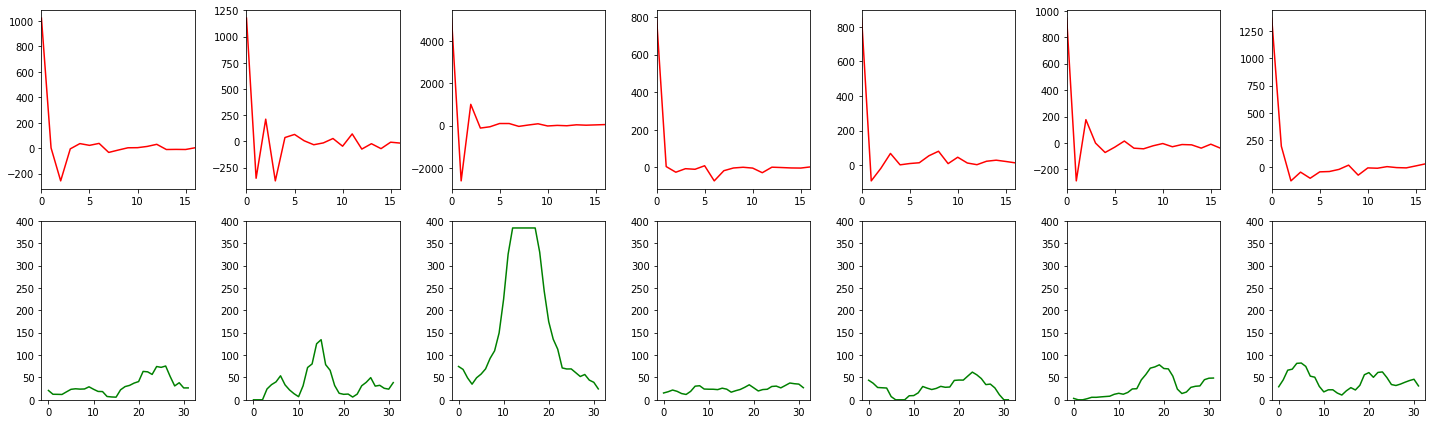

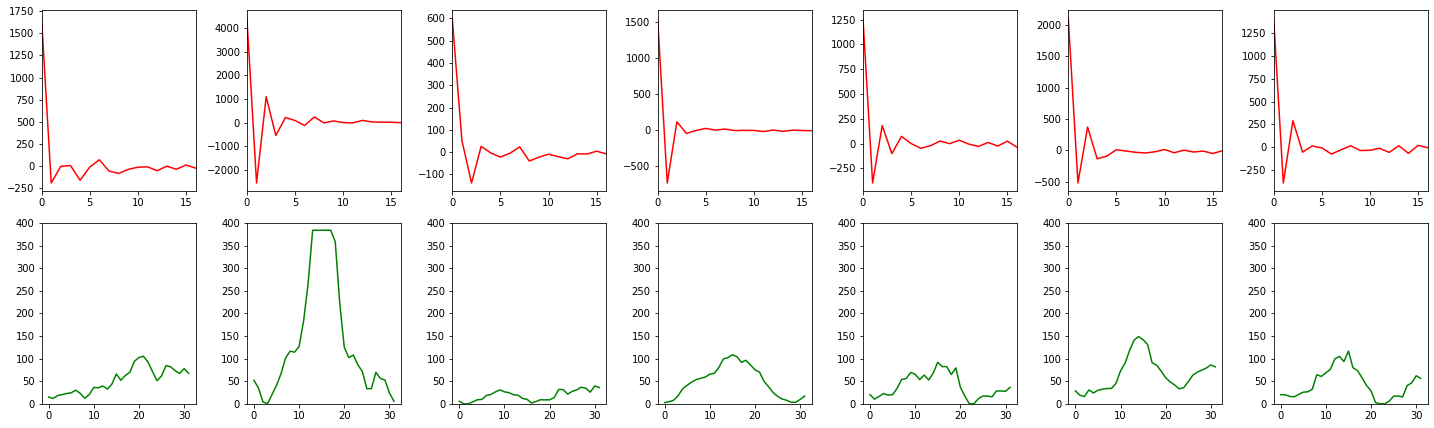

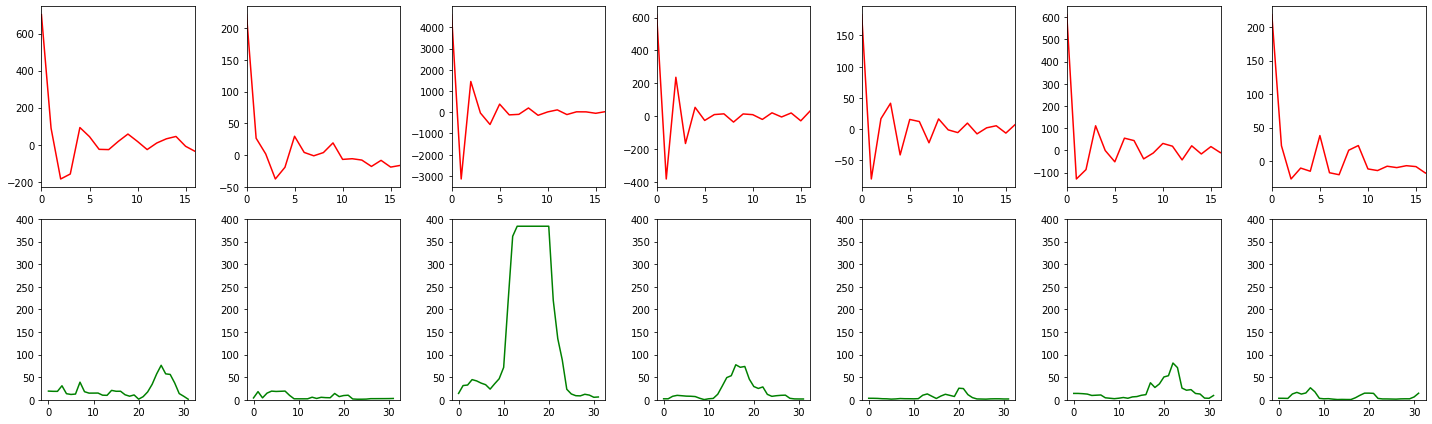

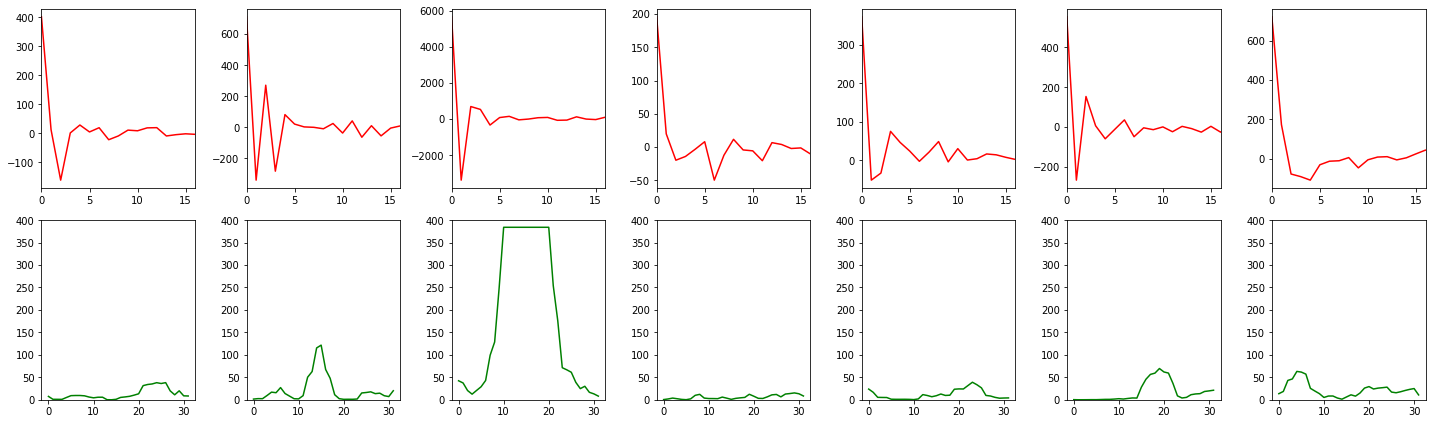

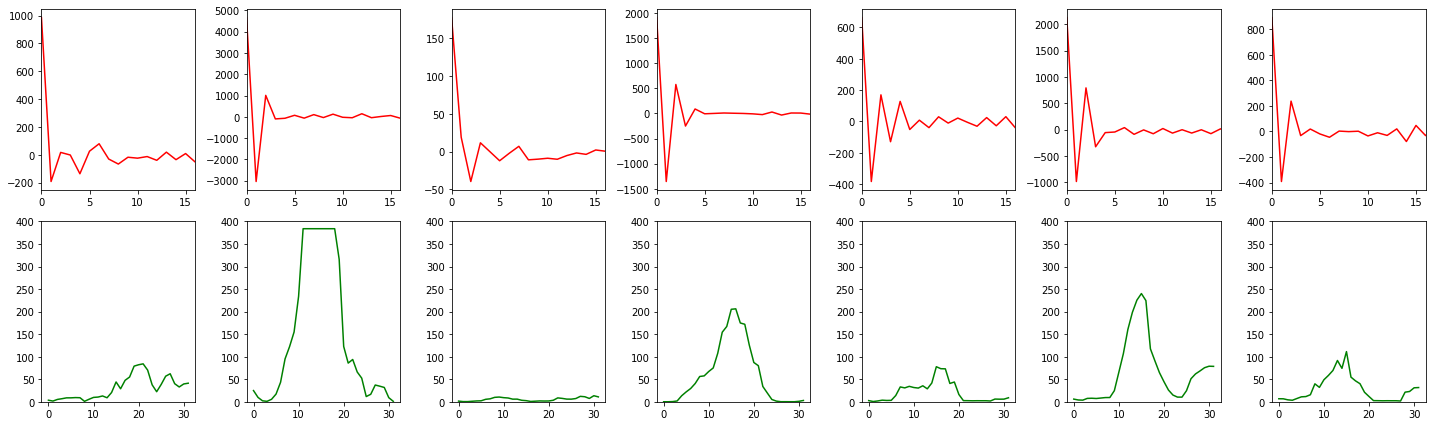

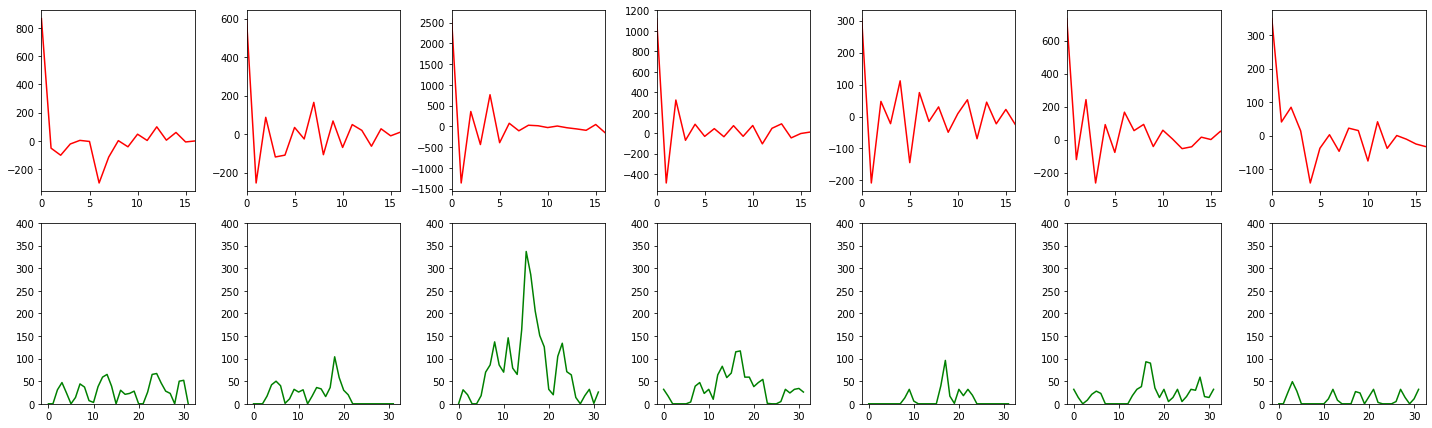

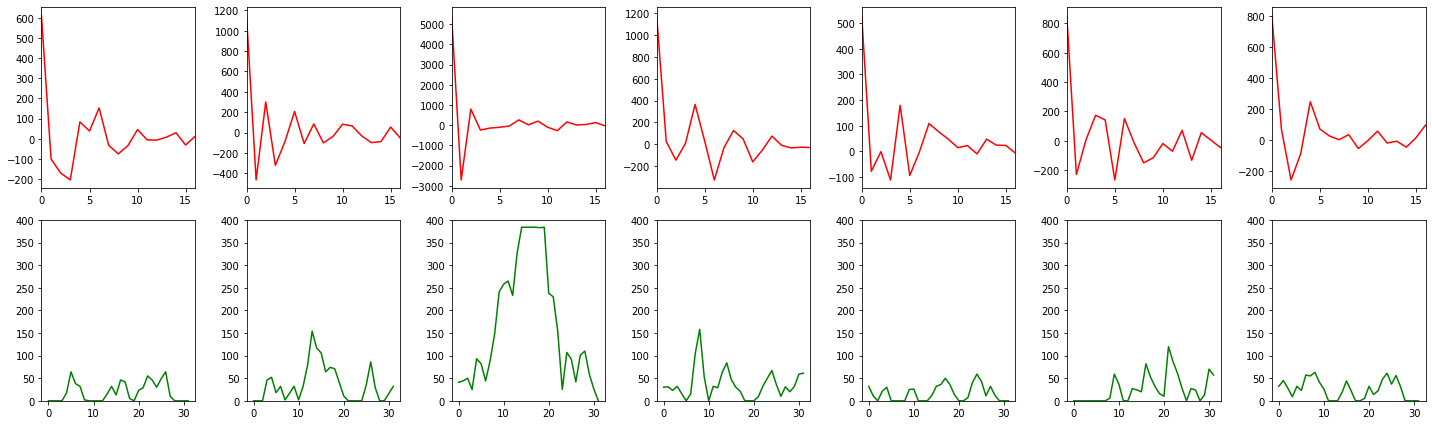

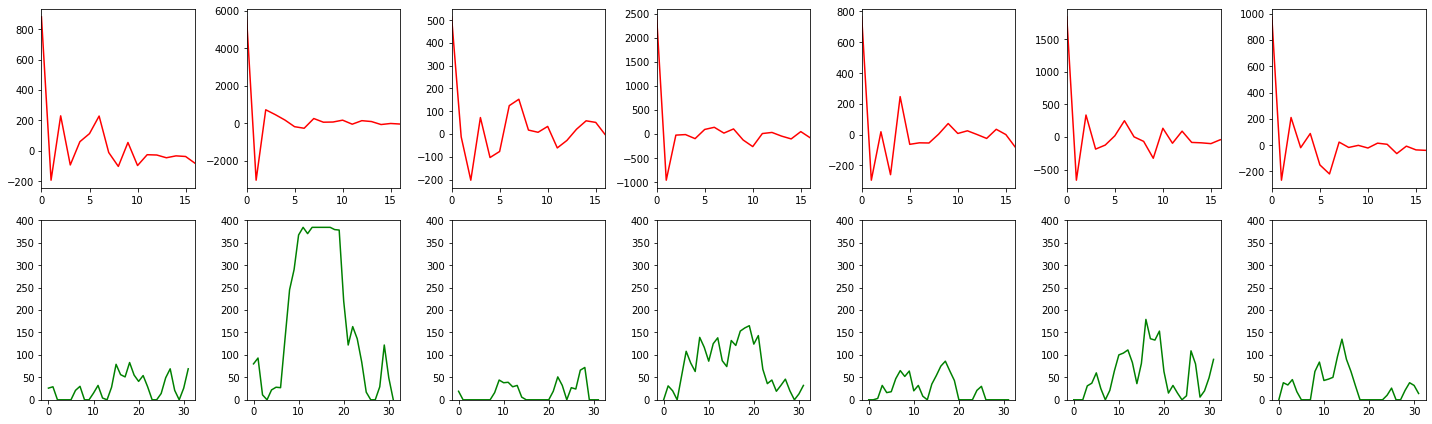

In [12]:
for base_dir in [
                '/home/shush/profile/basenji/data/HepG2_fold/', 
                 '/home/shush/profile/basenji/data/HepG2_sign/',
                 '/home/shush/profile/basenji/data/HepG2_raw/']:
    tfr_path = os.path.join(base_dir, 'tfrecords/*.tfr')
    tfr_files = glob.glob(tfr_path)
    out_file = os.path.join(base_dir, 'cov_and_fft.h5')
    tfdset = tf.data.TFRecordDataset(
        tfr_files,
        compression_type="ZLIB",
    )
    tfdset = tfdset.map(parse_proto)
    iterator = iter(tfdset)
    cov_dict = {}
    for i in range(n_plots):
        cov_dict[i] = []
        last_feature_tfrec, last_label_tfrec = iterator.get_next()
        for j in range(num_labels):
            cov_dict[i].append(last_label_tfrec[:,j])
    for i in cov_dict.keys():
        plot_one_seq(cov_dict[i])

    stats_file = os.path.join(base_dir, 'statistics.json')
    with open(stats_file) as stats_open:
        params = json.load(stats_open)
    total_seqs = params['train_seqs'] + params['valid_seqs'] + params['test_seqs']

    fft_array = np.zeros((total_seqs, 32, 7))
    cov_array = np.zeros((total_seqs, 32, 7))

    for i, data in enumerate(tfdset):
        last_feature_tfrec, last_label_tfrec = data
        x = tf.cast(last_label_tfrec, 'complex64')
        cov_array[i,:,:] = last_label_tfrec.numpy()
        fft_x = tf.signal.fft(x)
        fft_x = fft_x.numpy()
        fft_array[i,:,:] = fft_x
    h5f = h5py.File(out_file, 'w')
    h5f.create_dataset('coverage', data=cov_array)
    h5f.create_dataset('fft', data=fft_array)